In [1]:
# Imports
import numpy as np
from scipy.optimize import minimize
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

[*********************100%***********************]  5 of 5 completed


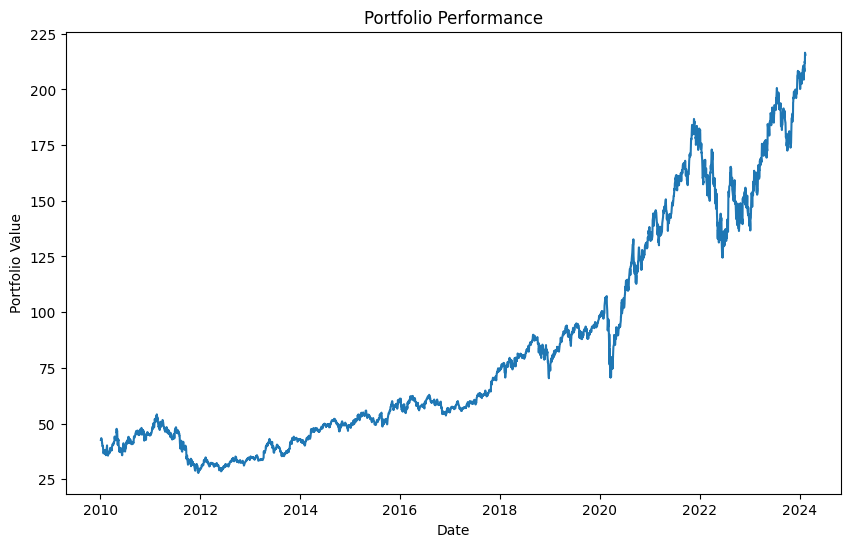

          Weight
Ticker          
AAPL    0.200235
MSFT    0.200260
AMZN    0.199728
FSLR    0.200072
SPG     0.199705


In [7]:
# Define the tickers to download
tickers = ['AAPL', 'MSFT', 'AMZN', 'FSLR', 'SPG']

# Download the historical prices for the tickers
today = date.today()
date_string = today.strftime("%Y-%m-%d")
prices = yf.download(tickers, start="2010-01-01", end=date_string)['Adj Close']

# Calculate the returns and expected returns for the assets
returns = prices.pct_change().dropna()
expected_returns = returns.mean()
cov_matrix = returns.cov()

# Define the portfolio optimization problem using scipy.optimize.minimize
n_assets = len(tickers)

# Define the expected returns and covariance matrix as arrays
S = cov_matrix.values
pbar = expected_returns.values.reshape((n_assets,))

# Define the constraints on the portfolio weights
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0})
bnds = tuple((0, 1) for i in range(n_assets))

# Define the objective function to minimize
def obj_fun(x):
    return 0.5 * np.dot(x.T, np.dot(S, x)) - np.dot(pbar.T, x)

# Solve for the optimal portfolio weights
x0 = np.zeros(n_assets)
res = minimize(obj_fun, x0, method='SLSQP', bounds=bnds, constraints=cons)

# Get the optimal weights from the optimization result
weights = res.x

# Define the portfolio values
portfolio_value = (prices * weights).sum(axis=1)

# Plot the portfolio values
plt.figure(figsize=(10,6))
plt.plot(portfolio_value.index, portfolio_value)
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Performance')
plt.show()

# Print a table with the portfolio weights
weights_df = pd.DataFrame({'Ticker': tickers, 'Weight': weights})
weights_df.set_index('Ticker', inplace=True)
print(weights_df)


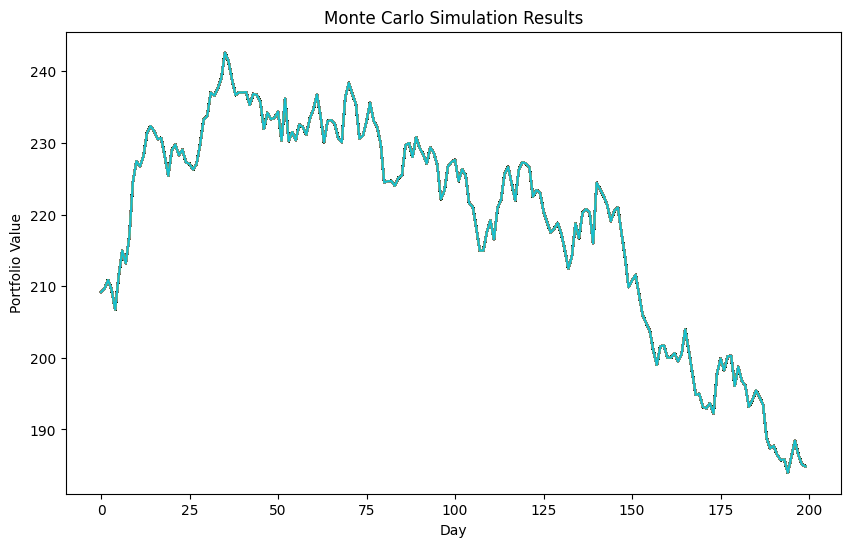

In [8]:
# Specify the total amount to invest
total_investment = float(input("Enter the total amount to invest: "))

# Calculate the amount to invest in each stock
investments = weights * total_investment

# Get the current prices for the stocks
current_prices = yf.download(tickers, end="2023-04-20")['Adj Close'].iloc[-1]

# Calculate the number of shares to purchase for each stock
num_shares = investments / current_prices
num_shares = np.floor(num_shares / 0.05) * 0.05  # round down to nearest 0.05

df = pd.DataFrame({'Investment': investments, "Number of Shares to Purchase" : num_shares})
print(df)


Enter the total amount to invest: 100
[*********************100%***********************]  5 of 5 completed
      Investment  Number of Shares to Purchase
AAPL   20.023472                          0.10
AMZN   20.026015                          0.15
FSLR   19.972839                          0.05
MSFT   20.007160                          0.05
SPG    19.970513                          0.15


In [ ]:
# Define the number of simulation days and simulations to run
n_days = 200
n_sims = 1000

# Define the daily returns using the expected returns and covariance matrix
daily_returns = np.random.multivariate_normal(expected_returns, cov_matrix, n_days)

# Create an array to store the simulation results
simulation_values = np.zeros((n_days, n_sims))

# Get the starting portfolio value
start_value = portfolio_value.iloc[-1]

# Run the simulation
for i in range(n_sims):
    # Get the starting returns
    start_returns = returns.iloc[-1]
    
    # Calculate the portfolio values for each day of the simulation
    portfolio_values = np.zeros(n_days)
    portfolio_values[0] = start_value
    for j in range(1, n_days):
        # Calculate the returns for the current day
        returns_today = daily_returns[j]
        
        # Calculate the new portfolio value for the current day
        portfolio_value_today = (1 + np.dot(weights.T, returns_today)) * portfolio_values[j-1]
        
        # Store the new portfolio value
        portfolio_values[j] = portfolio_value_today
    
    # Store the portfolio values in the simulation results array
    simulation_values[:,i] = portfolio_values

# Plot the simulation results
plt.figure(figsize=(10,6))
plt.plot(simulation_values)
plt.xlabel('Day')
plt.ylabel('Portfolio Value')
plt.title('Monte Carlo Simulation Results')
plt.show()
